## Reference

* 데이터 증강:
  * terryum 님의 웨어러블 센서 데이터 증강 기법 - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data 

* 모델구현
  * https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/?utm_source=pocket_mylist
    1. LSTM 단독모델
    2. CNN-LSTM 결합모델
    3. ConvLSTM 모델
    비교 3가지 돌려봤는데 CNN-LSTM 이 가장 성능이 좋아서 선택
  * CNN단독 모델 보다 CNN-LSTM 모델이 우수한 이유 설명 - 미세먼지 예측 성능 개선을 위한 CNN-LSTM 결합 방법 http://koreascience.or.kr/article/JAKO202005653789386.page
  * 그외 시계열 데이터 LSTM 응용 방법 - https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

* 교차검증 및 성능 강화
  * early stopping 과 callback 을 사용하여 과적합을 방지할 수 있다. - https://tykimos.github.io/2017/07/09/Early_Stopping/ 
  * 앙상블 기법
    * softvoting
    * stacking - https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 기본 directory 설정
import os
os.chdir('/content/drive/MyDrive/Monthly_Workout')

In [4]:
# 모듈 불러오기
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import pi
import matplotlib.pyplot as plt

In [5]:
# 데이터 불러오기
path = './' # 기본 directory 경로에 추가 할 경로

train = pd.read_csv(path + 'train_features.csv')
train_labels = pd.read_csv(path + 'train_labels.csv')
test = pd.read_csv(path + 'test_features.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [6]:
act_list=train.iloc[:,2:].columns
acc_list=['acc_x','acc_y','acc_z']
gy_list=['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [7]:
# acc 데이터와 gy 데이터로 분할
def sensor_split(data):
    X_acc = []
    X_gy = []

    for i in tqdm(data['id'].unique()):
        temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
        temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
        X_acc.append(temp_acc)
        X_gy.append(temp_gy)
      
    X_acc = np.array(X_acc).reshape(-1,600,3)
    X_gy = np.array(X_gy).reshape(-1,600,3)

    return X_acc, X_gy

In [8]:
# 데이터 증강

def permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return (X_new)

def aug(data, uid, shift):
    shift_data = np.roll(data[uid], shift, axis=0)
    return shift_data
def rolling(data):
    aug_data=[]
    for i in range(data.shape[0]):
        temp=list((aug(data,i,int(random.random()*600))))
        aug_data.append(temp)
    return np.array(aug_data)

In [9]:
# 데이터 증강 (반복하고 싶은 만큼 조정)
def start_augmentation(train, train_labels):
    # acc, gy 데이터 분할
    X_train_mod=pd.merge(train,train_labels,how='left',on='id')
    X_train_acc, X_train_gy= sensor_split(X_train_mod)

    # 증강시키고 추가할 임시 데이터 복사본
    X_train_acc_temp = X_train_acc.copy()
    X_train_gy_temp = X_train_gy.copy()

    # label 데이터 변환
    y_train = train_labels['label']
    y_train_total = np.append(y_train, y_train, axis=0)

    rep = 3 # 5이상의 경우 reshape 과정에서 reset될 가능성 높음
    for i in range(rep):
        X_train_acc_roll = rolling(X_train_acc_temp)
        X_train_acc_rp = permutation(rolling(X_train_acc_temp)) # rolling + permutation

        X_train_gy_roll = rolling(X_train_gy_temp)
        X_train_gy_rp = permutation(rolling(X_train_gy_temp)) # rolling + permutation

        # 증강시킨 데이터 원래 데이터에 추가
        X_train_acc = np.append(X_train_acc, X_train_acc_roll, axis=0)
        X_train_acc = np.append(X_train_acc, X_train_acc_rp, axis=0)

        X_train_gy = np.append(X_train_gy, X_train_gy_roll, axis=0)
        X_train_gy = np.append(X_train_gy, X_train_gy_rp, axis=0)

        y_train_total = np.append(y_train_total, y_train, axis=0)
        if i != (rep-1): # 마지막 한 번 제외
            y_train_total = np.append(y_train_total, y_train, axis=0)

    return X_train_acc, X_train_gy, y_train_total 

In [10]:
X_train_acc, X_train_gy, y_train_total = start_augmentation(train, train_labels)

print(X_train_acc.shape, X_train_gy.shape, y_train_total.shape)

100%|██████████| 3125/3125 [00:14<00:00, 211.74it/s]


(21875, 600, 3) (21875, 600, 3) (21875,)


In [11]:
# np array 형태를 dataframe 으로 변환
def np_to_df(X_train_acc, X_train_gy):
    acc = [e for sl in X_train_acc for e in sl]
    gy = [e for sl in X_train_gy for e in sl]

    df_report_acc = np.stack(acc, axis = 0)
    df_report_gy = np.stack(gy, axis = 0)

    df_acc = pd.DataFrame(df_report_acc, columns= ['acc_x', 'acc_y', 'acc_z']) 
    df_gy = pd.DataFrame(df_report_gy, columns= ['gy_x', 'gy_y', 'gy_z']) 

    # acc, gy 데이터프레임 병합
    df_aug_result = pd.concat([df_acc, df_gy], axis = 1)
    
    return df_aug_result

In [12]:
train = np_to_df(X_train_acc, X_train_gy)
train

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...
13124995,-0.999653,-0.245634,-0.085753,-32.359634,-19.109490,-4.031760
13124996,-1.011812,-0.271123,-0.061414,-6.089707,-16.719754,-5.953915
13124997,-1.005480,-0.299167,-0.068076,15.469206,-15.591417,-8.232097
13124998,-1.000123,-0.304406,-0.067864,22.638392,-20.120903,-11.207780


In [14]:
# 시각화를 위해서 id 로 묶어주기 위해 잠시 생성
val_id = []
n = int(len(train))

# 600번씩 반복되도록 임의로 배열 생성
for i in range(n//600):
    for j in range(600):
        val_id.append(i)

train.insert(0, 'id', val_id) # 리스트값 id 열에 붙여넣기
train.head(603)

,id,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...
598,0,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577
599,0,1.138159,-0.426846,-0.430263,-15.891015,21.675950,32.123007
600,1,-0.211795,-0.078760,0.854627,18.231943,10.211164,7.390348
601,1,-0.256963,-0.018555,0.802172,26.524263,0.980852,7.947258


### 증강시킨 데이터 비교해보기
1. 원래 id 0 번째의 데이터 - Shoulder Press (dumbell)
2. id 0 의 데이터를 Permutation 한 데이터
3. id 0 의 데이터를 Rolling + Permutation 한 데이터

확인해보면 파형은 비슷하지만 약간씩 변형된 데이터를 확인할 수 있다.  
그러므로 같은 동작이라고 판단하고 label 데이터를 붙여주어 학습시켰다.

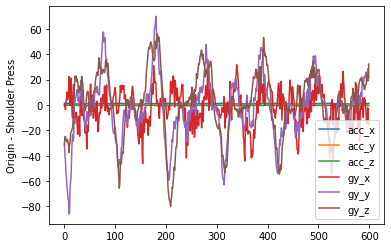

In [40]:
#id 별 동작들의 흐름 살펴보기
n_id = 0 # 원하는 id 별 증강 데이터 확인 (0의 경우 0 번째 데이터)
ex1=train[train['id']==n_id]
ex1.iloc[:,1:].plot()
plt.ylabel('Origin - Shoulder Press')
plt.show()

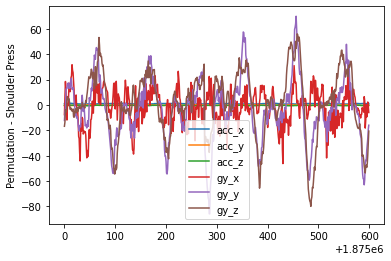

In [41]:
ex1=train[train['id']==n_id+3125]
ex1.iloc[:,1:].plot()
plt.ylabel('Permutation - Shoulder Press')
plt.show() # peak를 찍던 왼쪽에 높은 부분이 오르쪽에 가 있는 것을 확인할 수 있다

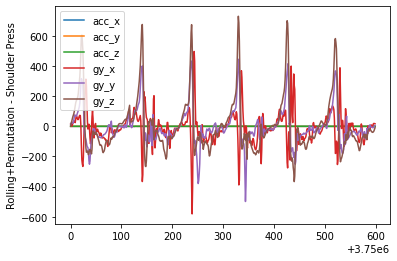

In [42]:
ex1=train[train['id']==n_id+6250]
ex1.iloc[:,1:].plot()
plt.ylabel('Rolling+Permutation - Shoulder Press')
plt.show() # 파형은 비슷하면서 변형된 모습을 볼 수 있다.

In [ ]:
train.drop(['id'], axis=1, inplace=True) # id 의 활용은 끝났으니 제거

In [ ]:
# 가속도
train['acc_t'] = (train['acc_x'] ** 2) + (train['acc_y'] ** 2) + (train['acc_z'] ** 2) ** (1/3)
test['acc_t'] = (test['acc_x'] ** 2) + (test['acc_y'] ** 2) + (test['acc_z'] ** 2) ** (1/3)

train['gy_t'] = (train['gy_x'] ** 2) + (train['gy_y'] ** 2) + (train['gy_z'] ** 2) ** (1/3)
test['gy_t'] = (test['gy_x'] ** 2) + (test['gy_y'] ** 2) + (test['gy_z'] ** 2) ** (1/3)

# Signal 극대화 (peak 캐치 유용)
train['acc_mag'] = (train['acc_x'] ** 2) + (train['acc_y'] ** 2) + (train['acc_z'] ** 2)
test['acc_mag'] = (test['acc_x'] ** 2) + (test['acc_y'] ** 2) + (test['acc_z'] ** 2)

train['gy_mag'] = (train['gy_x'] ** 2) + (train['gy_y'] ** 2) + (train['gy_z'] ** 2)
test['gy_mag'] = (test['gy_x'] ** 2) + (test['gy_y'] ** 2) + (test['gy_z'] ** 2)

In [ ]:
# vector
train['acc_vec'] = np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2)+(train['acc_z'] ** 2))
test['acc_vec'] = np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2)+(test['acc_z'] ** 2))

train['gy_vec'] = np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2)+(train['gy_z'] ** 2))
test['gy_vec'] = np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2)+(test['gy_z'] ** 2))

# 자이로스코프 무게중심
train['gy_gravity'] = (train['gy_x']+train['gy_y']+train['gy_z'])/3
test['gy_gravity'] = (test['gy_x']+test['gy_y']+test['gy_z'])/3

In [ ]:
# roll & pitch
train['roll'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2))
test['roll'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2))

train['pitch'] = np.arctan(train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2))
test['pitch'] = np.arctan(test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2))

train['math_roll'] = np.arctan(- train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2)) * (180/pi)
test['math_roll'] = np.arctan(- test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2)) * (180/pi)

train['math_pitch'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2)) * (180/pi)
test['math_pitch'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2)) * (180/pi)

train['gy_roll'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2))
test['gy_roll'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2))

train['gy_pitch'] = np.arctan(train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2))
test['gy_pitch'] = np.arctan(test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2))

train['gy_math_roll'] = np.arctan(- train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2)) * (180/pi)
test['gy_math_roll'] = np.arctan(- test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2)) * (180/pi)

train['gy_math_pitch'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2)) * (180/pi)
test['gy_math_pitch'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2)) * (180/pi)

print(train.shape)
train

(13125000, 21)


,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_t,gy_t,acc_mag,gy_mag,acc_vec,gy_vec,gy_gravity,roll,pitch,math_roll,math_pitch,gy_roll,gy_pitch,gy_math_roll,gy_math_pitch
0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.767177,943.603223,1.508855,1936.968046,1.228355,44.010999,-20.938910,-0.146550,1.380095,-79.073624,-8.396683,-0.767200,-0.013443,0.770209,-43.957305
1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,2.019429,1540.494535,1.731038,2153.327355,1.315689,46.403958,-21.254406,-0.151814,1.364146,-78.159835,-8.698302,-1.003661,0.006532,-0.374246,-57.505519
2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,2.140496,1968.439749,1.804277,2585.867212,1.343234,50.851423,-24.253157,-0.145773,1.330405,-76.226605,-8.352177,-1.050508,-0.071194,4.079137,-60.189701
3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,2.084285,2889.189647,1.771478,3633.811839,1.330969,60.281107,-26.112956,-0.173958,1.331665,-76.298763,-9.967037,-1.095444,0.045021,-2.579501,-62.764338
4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,2.094771,3380.757973,1.777076,4153.376248,1.333070,64.446693,-27.193696,-0.141316,1.350615,-77.384519,-8.096783,-1.116383,0.066565,-3.813876,-63.964038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124995,0.018779,-0.807443,0.554164,-22.601856,-77.236248,29.036708,1.326988,6485.728913,0.959415,7319.412239,0.979497,85.553564,-23.600465,-0.969043,0.019173,-1.098533,-55.522082,-1.126195,-0.267357,15.318453,-64.526240
13124996,0.041712,-0.836581,0.524693,-14.070432,-81.195910,35.156341,1.352142,6801.484619,0.976911,8026.721218,0.988388,89.591971,-20.036667,-1.009207,0.042214,-2.418698,-57.823299,-1.134411,-0.157703,9.035717,-64.996988
13124997,0.054006,-0.855127,0.518431,-4.499522,-91.377167,37.055988,1.379506,8381.147335,1.002929,9743.178685,1.001464,98.707541,-19.606901,-1.023390,0.053953,-3.091277,-58.635903,-1.182978,-0.045600,2.612698,-67.779667
13124998,0.082243,-0.893392,0.510886,8.925271,-95.855257,34.708324,1.443984,9278.531014,1.065917,10472.558426,1.032433,102.335519,-17.407221,-1.045802,0.079744,-4.569001,-59.920048,-1.213016,0.087327,-5.003452,-69.500675


In [ ]:
# Scaling 원하는 걸로 사용
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

scaler = RobustScaler()
train = scaler.fit_transform(train)
test.drop(['id', 'time'], axis=1, inplace=True)
test = scaler.transform(test)
train

array([[ 1.93489817,  0.03657354, -0.31330862, ...,  0.05924213,
        -0.05924213, -0.71658616],
       [ 2.01969699,  0.00673528, -0.37289479, ...,  0.07768724,
        -0.07768724, -0.94204715],
       [ 2.0372705 ,  0.01260973, -0.49722803, ...,  0.0059123 ,
        -0.0059123 , -0.98671563],
       ...,
       [ 0.73779949, -0.9920496 ,  0.85551785, ...,  0.02954682,
        -0.02954682, -1.11302315],
       [ 0.76714036, -1.05029596,  0.84229388, ...,  0.15229592,
        -0.15229592, -1.1416631 ],
       [ 0.82583791, -1.08011261,  0.85109713, ...,  0.21544581,
        -0.21544581, -1.14038692]])

In [ ]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Input
from keras.layers import TimeDistributed
from keras.layers import Activation, GlobalAveragePooling1D
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.layers.merge import concatenate

In [ ]:
len_features = train.shape[1] # feature 갯수
X = train.reshape(-1, 600, len_features)
X.shape

(21875, 600, 21)

In [ ]:
y = to_categorical(y_train_total) 
y.shape

(21875, 61)

In [ ]:
epochs, batch_size = 100, 64 # Ram 24GB 기준 256 이상 reset될 가능성 높음

In [ ]:
test_X = test.reshape(-1, 600, len_features)
test_X.shape

(782, 600, 21)

In [ ]:
epochs, batch_size = 30, 64
n_features, n_outputs = X.shape[2], y.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 6, 100
X = X.reshape((X.shape[0], n_steps, n_length, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_length, n_features))

In [ ]:
class Models:
    # 각종 사이즈는 다양하게 적용하여 stacking 쌓아 올리기
    def define_model_0():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_1():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_2():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=6, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_3():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=6, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_4():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(GlobalAveragePooling1D()))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_5():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=6, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(GlobalAveragePooling1D()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_6():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(GlobalAveragePooling1D()))
        model.add(LSTM(32))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_7():
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=6, activation='relu'), input_shape=(None,n_length,n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(TimeDistributed(GlobalAveragePooling1D()))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

In [ ]:
# 위의 모델들 학습하면서 stacking
for i in range(8):
    model = getattr(Models, f'define_model_{i}')()
    checkpoint_path = "checkpoint/cp.ckpt"
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
                                verbose=1, save_weights_only=True, 
                                save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, 
            validation_split=0.2, callbacks=[early_stopping, cp_callback])
    model.save(f'models/model_{i}.h5')
    tf.keras.backend.clear_session()

In [ ]:
# 저장한 모델 불러오기
for i in range(8): # 모델 갯수
    globals()[f'model{i}'] = load_model(f'models/model_{i}.h5')

In [ ]:
model0._name = 'Client0'
model1._name = 'Client1'
model2._name = 'Client2'
model3._name = 'Client3'
model4._name = 'Client4'
model5._name = 'Client5'
model6._name = 'Client6'
model7._name = 'Client7'

In [ ]:
inputs = Input(shape=(n_steps, n_length, n_features))

merge = concatenate([model0(inputs), model1(inputs), model2(inputs), model3(inputs), 
                    model4(inputs), model5(inputs), model6(inputs), model7(inputs)])
hidden = Dense(10, activation='relu')(merge)
output = Dense(61, activation='softmax')(hidden)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = "checkpoint/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.02, callbacks=[early_stopping, cp_callback])

Epoch 1/30
335/335 [==============================] - 60s 129ms/step - loss: 2.8233 - accuracy: 0.4927 - val_loss: 2.9787 - val_accuracy: 0.4726

Epoch 00001: val_loss improved from inf to 2.97872, saving model to checkpoint/cp.ckpt
Epoch 2/30
335/335 [==============================] - 35s 105ms/step - loss: 2.0859 - accuracy: 0.5490 - val_loss: 3.0952 - val_accuracy: 0.4315

Epoch 00002: val_loss did not improve from 2.97872
Epoch 3/30
335/335 [==============================] - 35s 105ms/step - loss: 1.9117 - accuracy: 0.5761 - val_loss: 3.2402 - val_accuracy: 0.4201

Epoch 00003: val_loss did not improve from 2.97872
Epoch 4/30
335/335 [==============================] - 35s 105ms/step - loss: 1.7900 - accuracy: 0.6038 - val_loss: 3.3488 - val_accuracy: 0.4087

Epoch 00004: val_loss did not improve from 2.97872
Epoch 5/30
335/335 [==============================] - 35s 105ms/step - loss: 1.7187 - accuracy: 0.6244 - val_loss: 3.4158 - val_accuracy: 0.3950

Epoch 00005: val_loss did not 

In [ ]:
prediction = model.predict(test_X)
prediction.shape

(782, 61)

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000265,0.000555,1.831344e-04,7.889649e-05,0.000339,1.639430e-06,0.000017,0.000593,0.001640,0.003428,0.145505,0.448136,2.373632e-03,0.261655,0.034549,0.000004,0.000005,0.003687,0.000353,0.000075,0.000523,1.432443e-03,1.354106e-05,0.002138,0.028914,0.000006,0.012658,0.000922,0.000060,2.830876e-04,0.002979,0.002780,0.000084,0.000079,7.808581e-07,6.647074e-06,0.005904,0.000041,0.000336,0.000026,0.000009,2.173188e-07,0.000446,0.000768,0.000323,0.000558,0.000352,0.000022,0.000015,0.000626,0.000003,1.696227e-02,3.425142e-03,1.007959e-03,0.005557,6.562532e-06,0.000063,0.000047,0.006832,0.000118,0.000227
1,3126,0.000556,0.000004,2.095053e-04,4.313315e-04,0.000123,5.296294e-04,0.000032,0.000074,0.000175,0.000135,0.000021,0.000048,1.984113e-05,0.000005,0.000092,0.000029,0.000118,0.000064,0.000106,0.000010,0.000033,1.135462e-04,4.070189e-04,0.000084,0.000188,0.000151,0.990982,0.000446,0.000063,4.048764e-05,0.000078,0.000015,0.000126,0.000031,8.743080e-05,1.150502e-04,0.000039,0.000080,0.000020,0.000011,0.000279,1.731373e-04,0.000011,0.000023,0.000050,0.000014,0.000036,0.000073,0.000189,0.001298,0.000632,7.771912e-05,1.483865e-05,3.218823e-05,0.000146,1.240795e-04,0.000153,0.000210,0.000078,0.000080,0.000414
2,3127,0.000100,0.018087,1.912311e-07,1.105333e-08,0.002896,7.745131e-07,0.000515,0.000070,0.000891,0.000011,0.001940,0.000019,1.822474e-06,0.000408,0.000035,0.000248,0.000027,0.000002,0.000335,0.000337,0.000322,4.157401e-07,3.641817e-09,0.000016,0.000476,0.005996,0.010276,0.001760,0.000473,8.238354e-07,0.000018,0.000032,0.000356,0.000058,1.101566e-04,8.234717e-07,0.000138,0.054571,0.000003,0.000002,0.000406,7.474995e-06,0.000087,0.002531,0.000812,0.885081,0.005538,0.000235,0.000182,0.000208,0.000116,5.496879e-07,1.892328e-06,2.177406e-08,0.000303,2.361107e-07,0.003556,0.000165,0.000039,0.000009,0.000189
3,3128,0.001654,0.000060,5.610238e-04,8.784476e-04,0.000722,2.025258e-03,0.000137,0.000512,0.000841,0.000662,0.000159,0.000328,1.410022e-04,0.000062,0.000301,0.000239,0.000366,0.000438,0.000590,0.000138,0.000360,6.414252e-04,5.583558e-04,0.000647,0.000767,0.000917,0.964169,0.002015,0.000461,2.231048e-04,0.000280,0.000078,0.000724,0.000121,2.750729e-04,4.028830e-04,0.000199,0.000489,0.000088,0.000081,0.001506,7.646101e-04,0.000069,0.000144,0.000292,0.000183,0.000458,0.000236,0.000812,0.004295,0.001457,3.663954e-04,1.121139e-04,1.029428e-04,0.000715,3.136211e-04,0.001213,0.000505,0.000309,0.000369,0.001466
4,3129,0.002359,0.000066,1.087026e-03,2.095253e-03,0.000872,2.219800e-03,0.000275,0.000520,0.001364,0.001112,0.000211,0.000453,2.413789e-04,0.000063,0.000759,0.000320,0.000697,0.000648,0.000765,0.000142,0.000245,7.824659e-04,2.835351e-03,0.000593,0.001250,0.000652,0.948661,0.001484,0.000630,4.374664e-04,0.000641,0.000185,0.000971,0.000258,5.684347e-04,8.516143e-04,0.000319,0.000438,0.000315,0.000196,0.001164,9.517164e-04,0.000156,0.000226,0.000362,0.000120,0.000285,0.000485,0.001144,0.005616,0.002748,6.485910e-04,2.037384e-04,2.713554e-04,0.000645,8.415297e-04,0.000833,0.001124,0.000602,0.000771,0.002220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.006149,0.001031,1.413109e-03,3.072813e-03,0.012486,3.655708e-03,0.004587,0.001102,0.005711,0.006047,0.000999,0.000958,1.520691e-03,0.000232,0.002731,0.007329,0.003626,0.001453,0.006676,0.003285,0.000977,1.604468e-03,2.022508e-02,0.002857,0.003622,0.003606,0.682333,0.002152,0.007510,2.535622e-03,0.004969,0.002304,0.011622,0.001539,1.555353e-02,2.922687e-03,0.002447,0.004265,0.004303,0.004633,0.004115,5.147588e-03,0.002438,0.003037,0.001620,0.001351,0.002173,0.005552,0.012806,0.017494,0.034678,1.3

In [ ]:
submission.to_csv('cnn_LSTM_stacked_9(jun).csv', index=False)